##### Feature Selection

Perform feature selection using the best model and dataset determined in model training

Basic Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Model imports

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

import warnings

Define evaluate_model function as in Model training

In [8]:
def evaluate_model(true, predicted, model, X_test):
    precision = precision_score(true, predicted , zero_division = 0)
    recall = recall_score(true, predicted , zero_division = 0)
    f1 = f1_score(true , predicted, zero_division = 0)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(true, y_pred_proba)
    pr_auc = average_precision_score(true, y_pred_proba)
    return precision, recall, f1, roc_auc, pr_auc

Load in the unscaled and balanced datasets

In [4]:
X_train=pd.read_csv('data/unscaled_balanced_X_train.csv')
y_train=pd.read_csv('data/unscaled_balanced_y_train.csv')

Load in the test datasets

In [5]:
X_test=pd.read_csv('data/X_test.csv')
y_test=pd.read_csv('data/y_test.csv')

Define Cat Boosting as baseline and run it.
Also output feature importance

In [11]:
models = {
    "GradientBoosting Classifier": GradientBoostingClassifier()
}
# define empty list
model_list = []
r2_list =[]

# for every model in the list
for i in range(len(list(models))):
    # set model to model at index i
    model = list(models.values())[i]

    # Train model
    model.fit(X_train, y_train) 

    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Make predictions
    y_train_pred = model.predict(X_train)
    accuracy_train = accuracy_score(y_train , y_train_pred)

    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test , y_test_pred)

    model_train_precision, model_train_recall, model_train_f1, model_train_roc_auc, model_train_pr_auc = evaluate_model(y_train, y_train_pred, model, X_train)
    model_test_precision, model_test_recall, model_test_f1, model_test_roc_auc, model_test_pr_auc = evaluate_model(y_test, y_test_pred, model, X_test)

    print(list(models.keys())[i])

    # append each model to model_list
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Training Accuracy: {:.4f}".format(accuracy_train))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- ROC_AUC: {:.4f}".format(model_train_roc_auc))
    print("- PR_AUC: {:.4f}".format(model_train_pr_auc))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Testing Accuracy: {:.4f}".format(accuracy_test))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- ROC_AUC: {:.4f}".format(model_test_roc_auc))
    print("- PR_AUC: {:.4f}".format(model_test_pr_auc))

    print('='*35)
    print('\n')

    # Extract feature importances from Gradient Boosting Classifier
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names)

    # sort feature importances and names
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    feature_names_sorted = feature_importances_sorted.index

    print(feature_importances_sorted)

c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoosting Classifier
Model performance for Training set
- Training Accuracy: 0.8455
- Precision: 0.8592
- Recall: 0.8265
- F1 Score: 0.8425
- ROC_AUC: 0.9298
- PR_AUC: 0.9404
----------------------------------
Model performance for Test set
- Testing Accuracy: 0.8136
- Precision: 0.4261
- Recall: 0.5501
- F1 Score: 0.4802
- ROC_AUC: 0.8229
- PR_AUC: 0.4490


HighBP                  0.364416
GenHlth                 0.214057
HighChol                0.125596
BMI                     0.062584
Age                     0.055309
HeartDiseaseorAttack    0.025731
DiffWalk                0.025325
Smoker                  0.022743
Fruits                  0.022248
Education               0.021607
PhysActivity            0.019441
HvyAlcoholConsump       0.011877
Veggies                 0.011676
Income                  0.006760
PhysHlth                0.006612
Stroke                  0.002443
AnyHealthcare           0.001573
dtype: float64


Observation: HighBP, GenHlth, HighChol and BMI have highest feature importance, PhysHealth, Stroke, anyhealthcare had lowest

Try iterative feature removal results. Iteratively remove 2 least important features from the feature importance sorted list

In [12]:
def iterative_feature_removal(X_train, y_train, X_test, y_test, feature_importance_sorted):
    """
    Iteratively remove 2 least important features and retrain GB model until 0 features.
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    feature_importance_sorted : DataFrame with features sorted by importance (most to least)
    
    Returns:
    --------
    results_df : DataFrame with model performance metrics at each iteration
    """
    
    # Initialize results list
    results = []
    
    # Get list of features from most to least important
    features_list = feature_importance_sorted.index.tolist()  # or feature_importance_sorted['feature'].tolist() depending on your df structure
    
    # Start with all features
    current_features = features_list.copy()
    
    iteration = 0
    while len(current_features) > 0:
        print(f"\n{'='*50}")
        print(f"Iteration {iteration + 1}: Training with {len(current_features)} features")
        print(f"{'='*50}")
        
        # Select current features for training and testing
        X_train_subset = X_train[current_features]
        X_test_subset = X_test[current_features]
        
        # Train model
        model = GradientBoostingClassifier(random_state=42)
        model.fit(X_train_subset, y_train)
        
        # Get predictions
        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test_subset)
        y_test_pred_proba = model.predict_proba(X_test_subset)[:, 1]
        
        # Calculate metrics for training set
        train_acc = accuracy_score(y_train, y_train_pred)
        train_precision, train_recall, train_f1, train_roc_auc, train_pr_auc = evaluate_model2(
            y_train, y_train_pred, model, X_train_subset
        )
        
        # Calculate metrics for test set
        test_acc = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
        test_pr_auc = average_precision_score(y_test, y_test_pred_proba)
        
        # Store results
        results.append({
            'num_of_features': len(current_features),
            'training_acc': train_acc,
            'test_acc': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'roc_auc': test_roc_auc,
            'pr_auc': test_pr_auc
        })
        
        # Print current results
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"F1 Score: {test_f1:.4f}")
        print(f"ROC AUC: {test_roc_auc:.4f}")
        print(f"PR AUC: {test_pr_auc:.4f}")
        
        # Remove 2 least important features for next iteration
        if len(current_features) > 2:
            current_features = current_features[:-2]  # Remove last 2 features (least important)
        elif len(current_features) == 2:
            current_features = current_features[:-2]  # Remove both remaining features
        else:
            current_features = []  # Remove the last feature
        
        iteration += 1
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Reorder columns to match your specified order
    results_df = results_df[['num_of_features', 'training_acc', 'test_acc', 
                             'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']]
    
    return results_df

Run the iterative feature removal

In [13]:
results_df = iterative_feature_removal(X_train, y_train, X_test, y_test, feature_importances_sorted)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


Iteration 1: Training with 17 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8455
Test Accuracy: 0.8136
Precision: 0.4261
Recall: 0.5501
F1 Score: 0.4802
ROC AUC: 0.8229
PR AUC: 0.4490

Iteration 2: Training with 15 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8460
Test Accuracy: 0.8133
Precision: 0.4258
Recall: 0.5536
F1 Score: 0.4814
ROC AUC: 0.8229
PR AUC: 0.4486

Iteration 3: Training with 13 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8441
Test Accuracy: 0.8136
Precision: 0.4269
Recall: 0.5569
F1 Score: 0.4833
ROC AUC: 0.8226
PR AUC: 0.4484

Iteration 4: Training with 11 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8424
Test Accuracy: 0.8116
Precision: 0.4225
Recall: 0.5560
F1 Score: 0.4802
ROC AUC: 0.8214
PR AUC: 0.4468

Iteration 5: Training with 9 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8358
Test Accuracy: 0.8051
Precision: 0.4128
Recall: 0.5800
F1 Score: 0.4823
ROC AUC: 0.8210
PR AUC: 0.4468

Iteration 6: Training with 7 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8244
Test Accuracy: 0.7947
Precision: 0.3984
Recall: 0.6114
F1 Score: 0.4825
ROC AUC: 0.8211
PR AUC: 0.4494

Iteration 7: Training with 5 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8190
Test Accuracy: 0.7869
Precision: 0.3891
Recall: 0.6339
F1 Score: 0.4822
ROC AUC: 0.8204
PR AUC: 0.4470

Iteration 8: Training with 3 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.7880
Test Accuracy: 0.7949
Precision: 0.3868
Recall: 0.5308
F1 Score: 0.4475
ROC AUC: 0.7880
PR AUC: 0.3725

Iteration 9: Training with 1 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.7208
Test Accuracy: 0.6453
Precision: 0.2707
Recall: 0.7474
F1 Score: 0.3974
ROC AUC: 0.6869
PR AUC: 0.2418

FINAL RESULTS SUMMARY
 num_of_features  training_acc  test_acc  precision   recall       f1  roc_auc   pr_auc
              17      0.845520  0.813643   0.426146 0.550057 0.480237 0.822928 0.448994
              15      0.845995  0.813288   0.425804 0.553583 0.481358 0.822930 0.448563
              13      0.844105  0.813643   0.426916 0.556857 0.483305 0.822582 0.448359
              11      0.842355  0.811574   0.422528 0.555975 0.480152 0.821360 0.446791
               9      0.835835  0.805109   0.412761 0.580028 0.482304 0.821016 0.446849
               7      0.824355  0.794702   0.398441 0.611384 0.482460 0.821132 0.449385
               5      0.819030  0.786917   0.389086 0.633925 0.482207 0.820395 0.447043
               3      0.787975  0.794860   0.386804 0.530790 0.447500 0.788012 0.372521
               1      0.720750  0.645281   0.270683 0.74

Even with just 3 or 1 features total, the model does not lose much accuracy in roc_auc or pr_auc. best roc_auc is with 15 features
Relatively good f1 score and pr_auc with just 7 features.
Model does not lose much accuracy with features removed

Define and run a function to run recursive feature elimination with cross validation to determine optimal features

RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)

Fitting RFECV... This may take a few minutes.
Starting with 17 features



c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Optimal number of features: 16
Features removed: 1

Selected features (16):
  1. HighBP
  2. HighChol
  3. BMI
  4. Smoker
  5. Stroke
  6. HeartDiseaseorAttack
  7. PhysActivity
  8. Fruits
  9. Veggies
  10. HvyAlcoholConsump
  11. GenHlth
  12. PhysHlth
  13. DiffWalk
  14. Age
  15. Education
  16. Income

Eliminated features (1):
  1. AnyHealthcare

MODEL PERFORMANCE WITH SELECTED FEATURES


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of Features: 16
Training Accuracy: 0.8460
Test Accuracy: 0.8137
Precision: 0.4263
Recall: 0.5508
F1 Score: 0.4806
ROC AUC: 0.8229
PR AUC: 0.4483


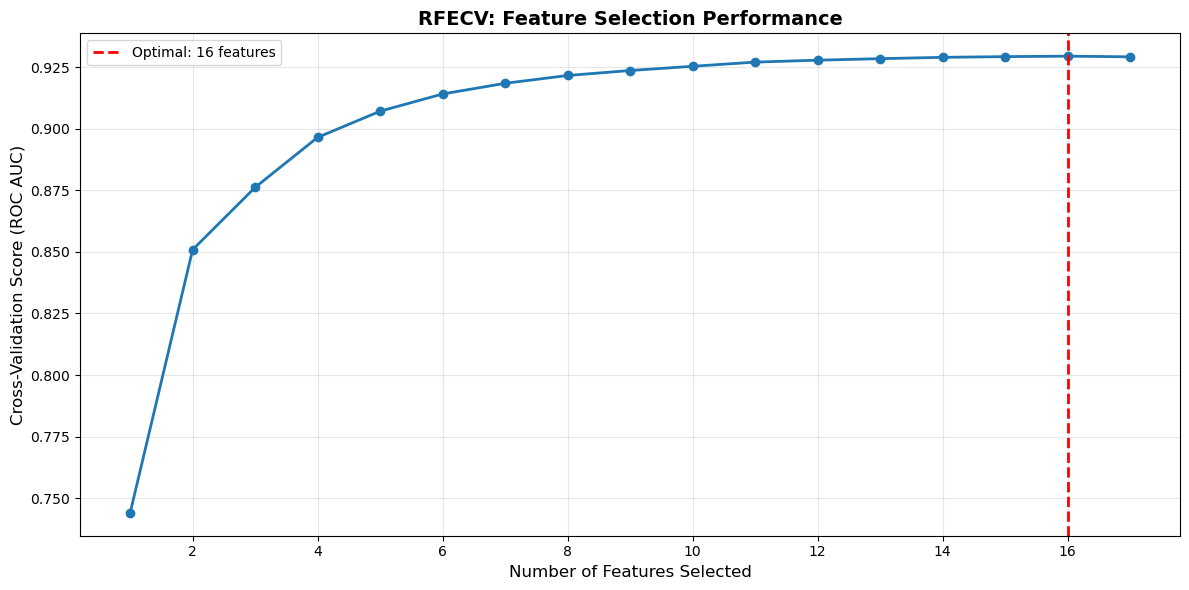


FEATURE RANKING
             Feature  Ranking  Selected
              HighBP        1      True
                 Age        1      True
            DiffWalk        1      True
            PhysHlth        1      True
             GenHlth        1      True
   HvyAlcoholConsump        1      True
           Education        1      True
             Veggies        1      True
        PhysActivity        1      True
HeartDiseaseorAttack        1      True
              Stroke        1      True
              Smoker        1      True
                 BMI        1      True
            HighChol        1      True
              Fruits        1      True
              Income        1      True
       AnyHealthcare        2     False

RFECV FINAL RESULTS
 num_of_features  training_acc  test_acc  precision   recall       f1  roc_auc   pr_auc
              16       0.84597  0.813663   0.426274 0.550812 0.480607 0.822855 0.448322

Original shape: (200000, 17)
Transformed shape: (200000, 16)


In [14]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def rfecv_feature_selection(X_train, y_train, X_test, y_test):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV) on GB model.
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    
    Returns:
    --------
    rfecv : Fitted RFECV object
    results_df : DataFrame with performance metrics using selected features
    """
    
    print("="*80)
    print("RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)")
    print("="*80)
    
    # Initialize the model
    gb_model = GradientBoostingClassifier(random_state=42)
    
    # Initialize RFECV with 5-fold cross-validation
    # Using StratifiedKFold to maintain class distribution in each fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rfecv = RFECV(
        estimator=gb_model,
        step=1,  # Remove 1 feature at each iteration
        cv=cv,
        scoring='roc_auc',  # You can change this to 'accuracy', 'f1', etc.
        min_features_to_select=1,
        n_jobs=-1  # Use all available cores
    )
    
    print("\nFitting RFECV... This may take a few minutes.")
    print(f"Starting with {X_train.shape[1]} features\n")
    
    # Fit RFECV
    rfecv.fit(X_train, y_train)
    
    # Print results
    print(f"\nOptimal number of features: {rfecv.n_features_}")
    print(f"Features removed: {X_train.shape[1] - rfecv.n_features_}")
    
    # Get selected feature names
    selected_features = X_train.columns[rfecv.support_].tolist()
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feat in enumerate(selected_features, 1):
        print(f"  {i}. {feat}")
    
    # Get eliminated feature names
    eliminated_features = X_train.columns[~rfecv.support_].tolist()
    if eliminated_features:
        print(f"\nEliminated features ({len(eliminated_features)}):")
        for i, feat in enumerate(eliminated_features, 1):
            print(f"  {i}. {feat}")
    
    # Transform training and test sets to use only selected features
    X_train_selected = rfecv.transform(X_train)
    X_test_selected = rfecv.transform(X_test)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE WITH SELECTED FEATURES")
    print("="*80)
    
    # Train final model with selected features
    final_model = GradientBoostingClassifier(random_state=42)
    final_model.fit(X_train_selected, y_train)
    
    # Get predictions
    y_train_pred = final_model.predict(X_train_selected)
    y_test_pred = final_model.predict(X_test_selected)
    y_test_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics for training set
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    test_pr_auc = average_precision_score(y_test, y_test_pred_proba)
    
    # Create results dictionary
    results = {
        'num_of_features': rfecv.n_features_,
        'training_acc': train_acc,
        'test_acc': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc,
        'pr_auc': test_pr_auc
    }
    
    # Print results
    print(f"\nNumber of Features: {results['num_of_features']}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"PR AUC: {test_pr_auc:.4f}")
    
    # Create DataFrame
    results_df = pd.DataFrame([results])
    
    # Plot cross-validation scores
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             marker='o', linewidth=2, markersize=6)
    plt.xlabel('Number of Features Selected', fontsize=12)
    plt.ylabel('Cross-Validation Score (ROC AUC)', fontsize=12)
    plt.title('RFECV: Feature Selection Performance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
                label=f'Optimal: {rfecv.n_features_} features', linewidth=2)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Create feature ranking DataFrame
    feature_ranking_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Ranking': rfecv.ranking_,
        'Selected': rfecv.support_
    }).sort_values('Ranking')
    
    print("\n" + "="*80)
    print("FEATURE RANKING")
    print("="*80)
    print(feature_ranking_df.to_string(index=False))
    
    return rfecv, results_df, selected_features, feature_ranking_df

# Run RFECV
rfecv_model, rfecv_results, selected_features, feature_ranking = rfecv_feature_selection(
    X_train, y_train, X_test, y_test
)

# Display final results
print("\n" + "="*80)
print("RFECV FINAL RESULTS")
print("="*80)
print(rfecv_results.to_string(index=False))

# Access the transformed datasets if needed
X_train_rfecv = rfecv_model.transform(X_train)
X_test_rfecv = rfecv_model.transform(X_test)

print(f"\nOriginal shape: {X_train.shape}")
print(f"Transformed shape: {X_train_rfecv.shape}")

Observation: Optimal feature is one feature removed: AnyHealthcare.
This makes sense since I already removed 4 features during initial feature selection with mutual info gain, and model performance doesn't change much with feature removal

Removing the feature as determined by RFECV for both X_train and X_test

In [6]:
X_train = X_train.drop(['AnyHealthcare'], axis=1)
X_test = X_test.drop(['AnyHealthcare'], axis=1)

Verify new feature shapes

In [7]:
X_train.shape

(200000, 16)

In [8]:
X_test.shape

(50736, 16)

Output the finalized csv

In [9]:
X_train.to_csv("data/final_X_train.csv", index=False)
X_test.to_csv("data/final_X_test.csv", index=False)

In [ ]:


##################
# See if I need to use this hyper param tuning here

# hyper param tuning on top 4 models
#xgb
#catboost
#adaboost
#gradient boosting

In [ ]:
from scipy.stats import uniform, randint
import time

def hyperparameter_tuning_boosting_models(X_train, y_train, X_test, y_test, n_iter=50, cv=5):
    """
    Perform hyperparameter tuning using RandomizedSearchCV for boosting models.
    Optimized for balanced binary classification (diabetes dataset).
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    n_iter : Number of parameter settings sampled (default=50)
    cv : Number of cross-validation folds (default=5)
    
    Returns:
    --------
    results_df : DataFrame with best parameters and performance metrics for each model
    best_models : Dictionary of best fitted models
    """
    
    # Define parameter distributions for each model
    # Optimized for balanced binary classification
    
    # 1. XGBoost Classifier
    xgb_param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.3
        'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
        'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),  # L1 regularization
        'reg_lambda': uniform(0, 1),  # L2 regularization
        'scale_pos_weight': [1],  # For balanced dataset
    }
    
    # 2. CatBoost Classifier
    catboost_param_dist = {
        'iterations': randint(100, 500),
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.29),
        'l2_leaf_reg': randint(1, 10),
        'border_count': randint(32, 255),
        'bagging_temperature': uniform(0, 1),
        'random_strength': uniform(0, 2),
        'subsample': uniform(0.6, 0.4),
    }
    
    # 3. AdaBoost Classifier
    adaboost_param_dist = {
        'n_estimators': randint(50, 500),
        'learning_rate': uniform(0.01, 1.99),  # 0.01 to 2.0
        'algorithm': ['SAMME', 'SAMME.R'],
    }
    
    # 4. Gradient Boosting Classifier
    gb_param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),
        'subsample': uniform(0.6, 0.4),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'loss': ['log_loss', 'exponential'],
    }
    
    # Dictionary of models and their parameter distributions
    models = {
        # 'XGBoost Classifier': (XGBClassifier(random_state=42, eval_metric='logloss'), xgb_param_dist),
        # 'CatBoost Classifier': (CatBoostClassifier(random_state=42, verbose=0), catboost_param_dist),
        # 'AdaBoost Classifier': (AdaBoostClassifier(random_state=42), adaboost_param_dist),
        'Gradient Boosting Classifier': (GradientBoostingClassifier(random_state=42), gb_param_dist)
    }
    
    # Cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Store results
    results = []
    best_models = {}
    
    print("="*100)
    print("HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH CV")
    print("="*100)
    print(f"Number of iterations per model: {n_iter}")
    print(f"Cross-validation folds: {cv}")
    print(f"Scoring metric: ROC AUC")
    print("="*100)
    
    # Iterate through each model
    for model_name, (model, param_dist) in models.items():
        print(f"\n{'='*100}")
        print(f"TUNING: {model_name}")
        print(f"{'='*100}")
        
        start_time = time.time()
        
        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=1,
            return_train_score=True
        )
        
        # Fit RandomizedSearchCV
        print(f"\nSearching through {n_iter} parameter combinations...")
        random_search.fit(X_train, y_train)
        
        # Get best model
        best_model = random_search.best_estimator_
        best_models[model_name] = best_model
        
        # Training predictions
        y_train_pred = best_model.predict(X_train)
        y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
        
        # Test predictions
        y_test_pred = best_model.predict(X_test)
        y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
        test_pr_auc = average_precision_score(y_test, y_test_pred_proba)
        
        # CV score
        cv_score = random_search.best_score_
        
        # Time taken
        elapsed_time = time.time() - start_time
        
        # Store results
        result = {
            'Model': model_name,
            'Best_CV_Score': cv_score,
            'Training_Acc': train_acc,
            'Test_Acc': test_acc,
            'Precision': test_precision,
            'Recall': test_recall,
            'F1_Score': test_f1,
            'ROC_AUC': test_roc_auc,
            'PR_AUC': test_pr_auc,
            'Time_Seconds': elapsed_time,
            'Best_Parameters': random_search.best_params_
        }
        results.append(result)
        
        # Print results
        print(f"\n{'─'*100}")
        print(f"RESULTS FOR {model_name}")
        print(f"{'─'*100}")
        print(f"Best CV Score (ROC AUC): {cv_score:.4f}")
        print(f"\nBest Parameters:")
        for param, value in random_search.best_params_.items():
            print(f"  • {param}: {value}")
        
        print(f"\n{'Training Set Performance':─^50}")
        print(f"  Training Accuracy: {train_acc:.4f}")
        
        print(f"\n{'Test Set Performance':─^50}")
        print(f"  Test Accuracy:     {test_acc:.4f}")
        print(f"  Precision:         {test_precision:.4f}")
        print(f"  Recall:            {test_recall:.4f}")
        print(f"  F1 Score:          {test_f1:.4f}")
        print(f"  ROC AUC:           {test_roc_auc:.4f}")
        print(f"  PR AUC:            {test_pr_auc:.4f}")
        
        print(f"\nTime Elapsed: {elapsed_time:.2f} seconds")
        print(f"{'='*100}\n")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Separate parameters into their own DataFrame for better display
    params_df = pd.DataFrame(results_df['Best_Parameters'].tolist(), index=results_df['Model'])
    
    # Drop Best_Parameters from main results
    results_summary = results_df.drop('Best_Parameters', axis=1)
    
    # Print final summary
    print("\n" + "="*100)
    print("FINAL SUMMARY - MODEL COMPARISON")
    print("="*100)
    print(results_summary.to_string(index=False))
    
    print("\n" + "="*100)
    print("BEST HYPERPARAMETERS FOR EACH MODEL")
    print("="*100)
    print(params_df.to_string())
    
    # Find best overall model
    best_model_idx = results_summary['ROC_AUC'].idxmax()
    best_overall_model = results_summary.loc[best_model_idx, 'Model']
    best_overall_score = results_summary.loc[best_model_idx, 'ROC_AUC']
    
    print("\n" + "="*100)
    print(f"🏆 BEST OVERALL MODEL: {best_overall_model}")
    print(f"   ROC AUC Score: {best_overall_score:.4f}")
    print("="*100)
    
    return results_df, best_models, params_df

In [ ]:
# Run hyperparameter tuning
results_df, best_models, params_df = hyperparameter_tuning_boosting_models(
    X_train, y_train, X_test, y_test, 
    n_iter=50,  # Increase for more thorough search (e.g., 100, 200)
    cv=5
)

# Access individual best models
best_xgb = best_models['XGBoost Classifier']
best_catboost = best_models['CatBoost Classifier']
best_adaboost = best_models['AdaBoost Classifier']
best_gb = best_models['Gradient Boosting Classifier']

# Save results to CSV (optional)
# results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
# params_df.to_csv('best_hyperparameters.csv')

HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH CV
Number of iterations per model: 50
Cross-validation folds: 5
Scoring metric: ROC AUC

TUNING: Gradient Boosting Classifier

Searching through 50 parameter combinations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



────────────────────────────────────────────────────────────────────────────────────────────────────
RESULTS FOR Gradient Boosting Classifier
────────────────────────────────────────────────────────────────────────────────────────────────────
Best CV Score (ROC AUC): 0.9403

Best Parameters:
  • learning_rate: 0.29619721161415
  • loss: exponential
  • max_depth: 3
  • max_features: None
  • min_samples_leaf: 3
  • min_samples_split: 18
  • n_estimators: 491
  • subsample: 0.8916028672163949

─────────────Training Set Performance─────────────
  Training Accuracy: 0.8656

───────────────Test Set Performance───────────────
  Test Accuracy:     0.8372
  Precision:         0.4781
  Recall:            0.4379
  F1 Score:          0.4571
  ROC AUC:           0.8241
  PR AUC:            0.4551

Time Elapsed: 2476.76 seconds


FINAL SUMMARY - MODEL COMPARISON
                       Model  Best_CV_Score  Training_Acc  Test_Acc  Precision   Recall  F1_Score  ROC_AUC  PR_AUC  Time_Seconds
Gradien

KeyError: 'XGBoost Classifier'

In [ ]:
# ───────────────Test Set Performance───────────────
#   Test Accuracy:     0.8372
#   Precision:         0.4781
#   Recall:            0.4379
#   F1 Score:          0.4571
#   ROC AUC:           0.8241
#   PR AUC:            0.4551

# Time Elapsed: 2476.76 seconds
# ====================================================================================================


# ====================================================================================================
# FINAL SUMMARY - MODEL COMPARISON
# ====================================================================================================
#                        Model  Best_CV_Score  Training_Acc  Test_Acc  Precision   Recall  F1_Score  ROC_AUC  PR_AUC  Time_Seconds
# Gradient Boosting Classifier       0.940304      0.865635  0.837196    0.47807 0.437854  0.457079 0.824094 0.45508   2476.762552

# ====================================================================================================
# BEST HYPERPARAMETERS FOR EACH MODEL
# ====================================================================================================
#                               learning_rate         loss  max_depth max_features  min_samples_leaf  min_samples_split  n_estimators  subsample
# Model                                                                                                                                         
# Gradient Boosting Classifier       0.296197  exponential          3         None                 3                 18           491   0.891603

# ====================================================================================================
# 🏆 BEST OVERALL MODEL: Gradient Boosting Classifier
#    ROC AUC Score: 0.8241
# ====================================================================================================